# Lecture 1: Polynomial regression

- INFO8010 Deep Learning, Gilles Louppe
- Lecture 1: [Fundamentals of machine learning](https://glouppe.github.io/info8010-deep-learning/?p=lecture1.md)

This notebook generates the running example figures for Lecture 1, illustrating supervised learning, empirical risk minimization, under/overfitting, and the bias-variance trade-off.

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cpu


## Data generating process

$$x \sim \mathcal{U}[-10, 10], \quad \epsilon \sim \mathcal{N}(0, \sigma^2), \quad y = g(x) + \epsilon$$

where $g$ is an unknown polynomial of degree 3.

In [2]:
def g(x):
    """True (unknown) function."""
    return 0.1 * (x - 2)**3 + x**2 - 6 * x + 1

def generate(n, sigma=10.0):
    """Sample n points from the data generating process."""
    x = torch.rand(n) * 20 - 10       # U[-10, 10]
    y = g(x) + sigma * torch.randn(n)  # g(x) + noise
    return x, y

In [3]:
torch.manual_seed(111)
x_train, y_train = generate(15)
xs = torch.linspace(-10, 10, 1000)

## Data

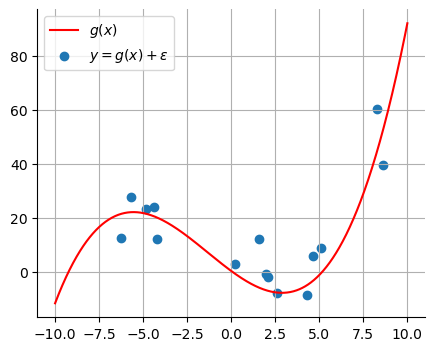

In [4]:
plt.figure(figsize=(5, 4))
plt.plot(xs, g(xs), c='r', label='$g(x)$')
plt.scatter(x_train, y_train, label=r'$y = g(x) + \epsilon$')
plt.grid(True)
plt.legend()
plt.show()

## Polynomial regression with PyTorch

We fit polynomials of degree $d$ using ordinary least squares:

$$\hat{\mathbf{w}} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}$$

where $\mathbf{X}$ is the Vandermonde matrix $[1, x, x^2, \ldots, x^d]$.

In [5]:
def vandermonde(x, degree):
    """Build the Vandermonde matrix [1, x, x^2, ..., x^d]."""
    return torch.stack([x**d for d in range(degree + 1)], dim=1)

def fit(x, y, degree):
    """Fit a polynomial of given degree via OLS. Returns coefficients w."""
    X = vandermonde(x, degree)
    return torch.linalg.lstsq(X, y).solution

def predict(x, w):
    """Evaluate the polynomial defined by w at points x."""
    X = vandermonde(x, len(w) - 1)
    return X @ w

def mse(y_true, y_pred):
    return (y_true - y_pred).pow(2).mean().item()

## Under-fitting and over-fitting

What happens when the hypothesis space $\mathcal{F}$ (polynomials of degree $d$) is too simple or too complex?

<>:9: SyntaxWarning: invalid escape sequence '\h'
<>:9: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_1528388/3291409216.py:9: SyntaxWarning: invalid escape sequence '\h'
  plt.title(f'degree = {degree}, $\hat{{R}}(f, d)$ = {error:.2f}')


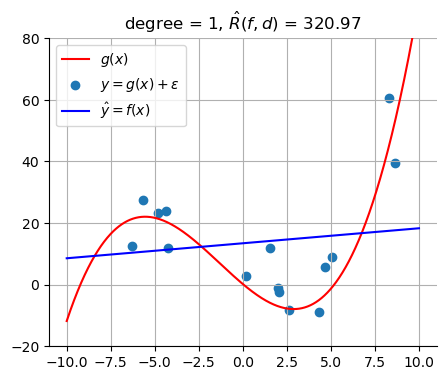

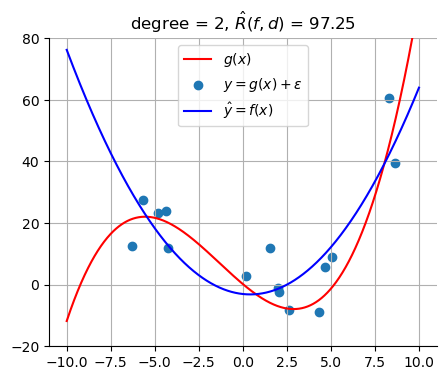

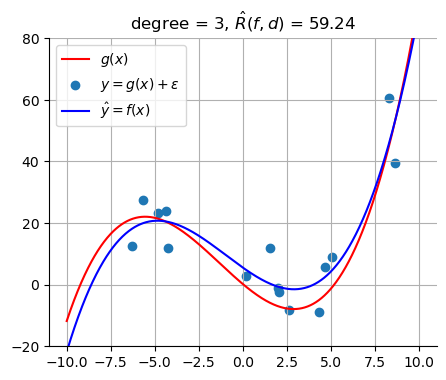

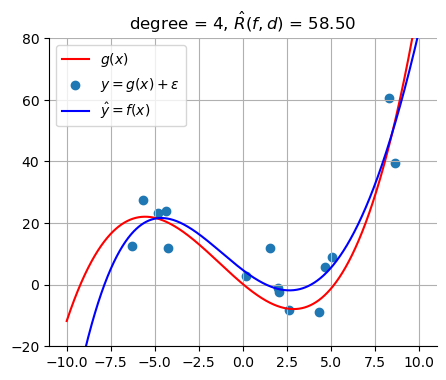

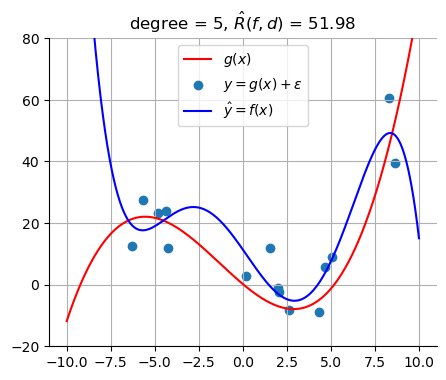

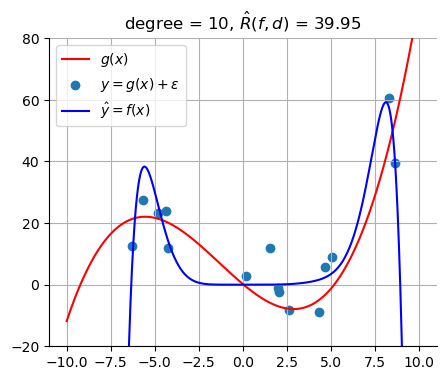

In [6]:
for degree in [1, 2, 3, 4, 5, 10]:
    w = fit(x_train, y_train, degree)
    error = mse(y_train, predict(x_train, w))

    plt.figure(figsize=(5, 4))
    plt.plot(xs, g(xs), c='r', label='$g(x)$')
    plt.scatter(x_train, y_train, label=r'$y = g(x) + \epsilon$')
    plt.plot(xs, predict(xs, w), c='b', label=r'$\hat{y} = f(x)$')
    plt.title(f'degree = {degree}, $\hat{{R}}(f, d)$ = {error:.2f}')
    plt.ylim(-20, 80)
    plt.grid(True)
    plt.legend()
    plt.show()

## Training error vs. test error

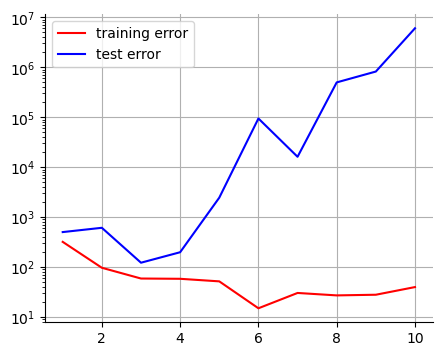

In [7]:
x_test, y_test = generate(10000)

train_errors, test_errors = [], []
for degree in range(1, 11):
    w = fit(x_train, y_train, degree)
    train_errors.append(mse(y_train, predict(x_train, w)))
    test_errors.append(mse(y_test, predict(x_test, w)))

plt.figure(figsize=(5, 4))
plt.plot(range(1, 11), train_errors, c='r', label='training error')
plt.plot(range(1, 11), test_errors, c='b', label='test error')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

## Convergence with $N$

With the correct hypothesis space (degree 3), the fit improves as $N$ grows.

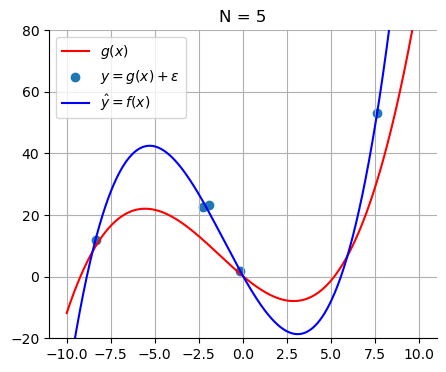

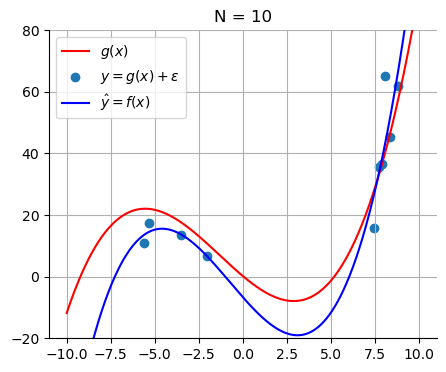

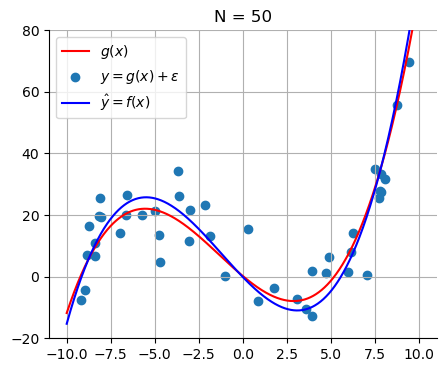

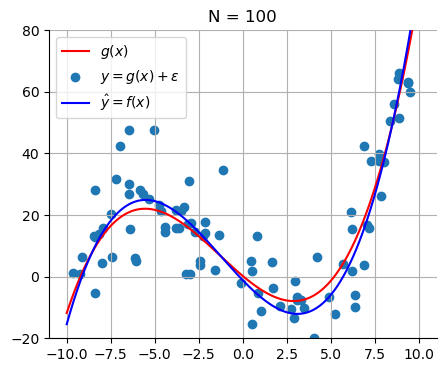

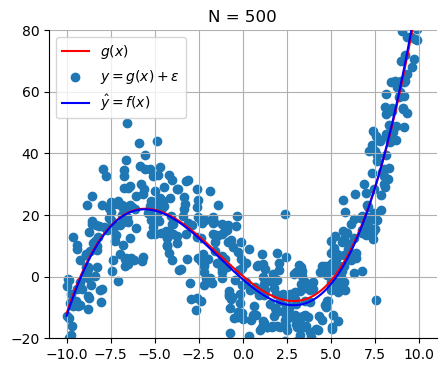

In [8]:
torch.manual_seed(777)

for N in [5, 10, 50, 100, 500]:
    x_n, y_n = generate(N)
    w = fit(x_n, y_n, degree=3)

    plt.figure(figsize=(5, 4))
    plt.plot(xs, g(xs), c='r', label='$g(x)$')
    plt.scatter(x_n, y_n, label=r'$y = g(x) + \epsilon$')
    plt.plot(xs, predict(xs, w), c='b', label=r'$\hat{y} = f(x)$')
    plt.title(f'N = {N}')
    plt.ylim(-20, 80)
    plt.grid(True)
    plt.legend()
    plt.show()

## Bias-variance decomposition

We sample 200 independent training sets, fit a polynomial on each, and overlay the predictions. The spread reveals the variance; the gap between the average prediction and $g(x)$ reveals the bias.

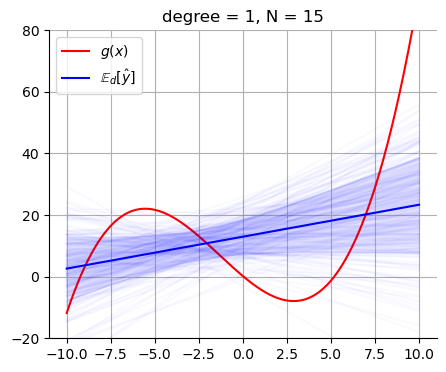

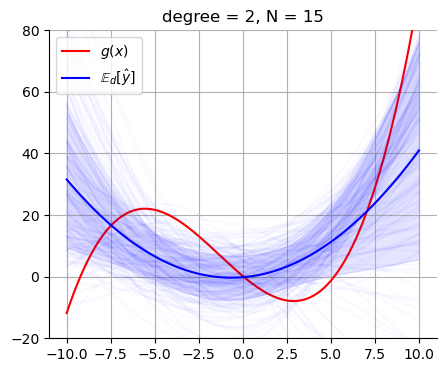

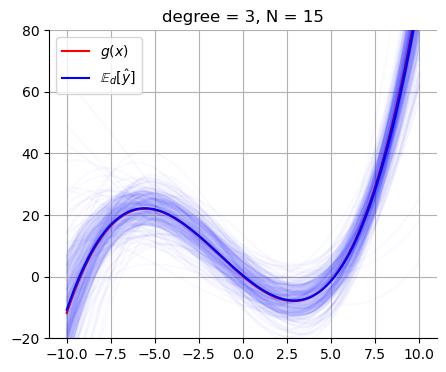

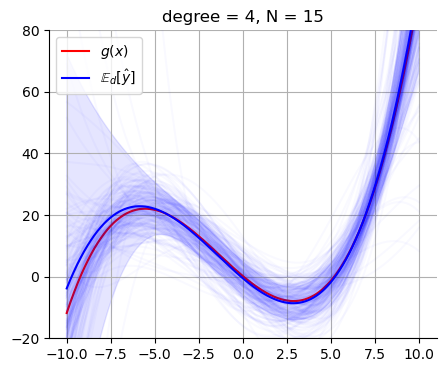

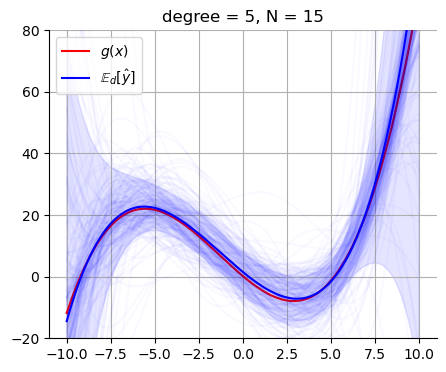

In [9]:
torch.manual_seed(42)

for degree in [1, 2, 3, 4, 5]:
    preds = []

    fig, ax = plt.subplots(figsize=(5, 4))
    ax.plot(xs, g(xs), c='r', label='$g(x)$')

    for _ in range(200):
        x_i, y_i = generate(15)
        w = fit(x_i, y_i, degree)
        pred = predict(xs, w)
        ax.plot(xs, pred, c='b', alpha=0.025)
        preds.append(pred)

    preds = torch.stack(preds)
    m = preds.mean(dim=0)
    s = preds.std(dim=0)
    ax.plot(xs, m, c='b', label=r'$\mathbb{E}_{d}[\hat{y}]$')
    ax.fill_between(xs, m - s, m + s, color='b', alpha=0.1)

    ax.set_title(f'degree = {degree}, N = 15')
    ax.set_ylim(-20, 80) 
    ax.grid(True)
    ax.legend(loc='upper left')
    plt.show()

## Overparameterized neural network

What happens with a massively overparameterized model? We train a 1-hidden layer ReLU MLP with **1 million** hidden units on just 15 data points.

Classical learning theory predicts catastrophic overfitting. In practice, the network generalizes surprisingly well.

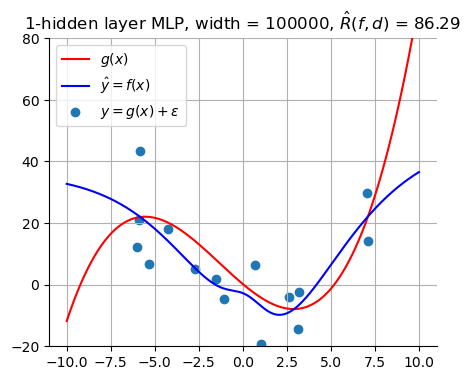

In [14]:
torch.manual_seed(7)
x_mlp, y_mlp_data = generate(15)

width = 100000
mlp = nn.Sequential(
    nn.Linear(1, width),
    nn.Sigmoid(),
    nn.Linear(width, 1)
).to(device)

X = x_mlp.unsqueeze(1).to(device)
Y = y_mlp_data.unsqueeze(1).to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

for step in range(1000):
    loss = ((mlp(X) - Y)**2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

with torch.no_grad():
    y_mlp = mlp(xs.unsqueeze(1).to(device)).squeeze().cpu()
    train_error = ((mlp(X).squeeze() - Y.squeeze())**2).mean().item()

plt.figure(figsize=(5, 4))
plt.plot(xs, g(xs), c='r', label='$g(x)$')
plt.plot(xs, y_mlp, c='b', label=r'$\hat{y} = f(x)$')
plt.scatter(x_mlp, y_mlp_data, label=r'$y = g(x) + \epsilon$')
plt.title(f'1-hidden layer MLP, width = {width}, $\\hat{{R}}(f, d)$ = {train_error:.2f}')
plt.ylim(-20, 80)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()